In [1]:
import os
import torch
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.image as mpimg
import random
import time
import copy
from torchmetrics import ConfusionMatrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

combined_location = './lung_colon_image_set/combined_image_sets'
lung_location = './lung_colon_image_set/lung_image_sets'
colon_location = './lung_colon_image_set/colon_image_sets'

In [3]:
input_size = (28, 28)
data_transforms = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor()
])

print("Initializing Datasets...")
dataset = datasets.ImageFolder(combined_location, data_transforms)

train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])
total_datasets = {'train' : train_data, 'val' : test_data}

print("Initializing Data Loaders...")

batch_size = 8

dataloaders_dict = {x: torch.utils.data.DataLoader(total_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

Initializing Datasets...
Initializing Data Loaders...


In [4]:
input_size = (28, 28)

colon_datasets = datasets.ImageFolder(colon_location, data_transforms)
lung_datasets = datasets.ImageFolder(lung_location, data_transforms)

print("Initializing Colon Dataset...")

train_size = int(0.8*len(colon_datasets))
test_size = len(colon_datasets) - train_size
train_data, test_data = torch.utils.data.random_split(colon_datasets, [train_size, test_size])
colon_datasets = {'train' : train_data, 'val' : test_data}

print("Initializing Colon Data Loader...")

colon_dataloaders_dict = {x: torch.utils.data.DataLoader(colon_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


print("Initializing Lung Dataset...")

train_size = int(0.8*len(lung_datasets))
test_size = len(lung_datasets) - train_size
train_data, test_data = torch.utils.data.random_split(lung_datasets, [train_size, test_size])
lung_datasets = {'train' : train_data, 'val' : test_data}

print("Initializing Lung Data Loader...")

lung_dataloaders_dict = {x: torch.utils.data.DataLoader(lung_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

Initializing Colon Dataset...
Initializing Colon Data Loader...
Initializing Lung Dataset...
Initializing Lung Data Loader...


Let's visualize some of the colon images

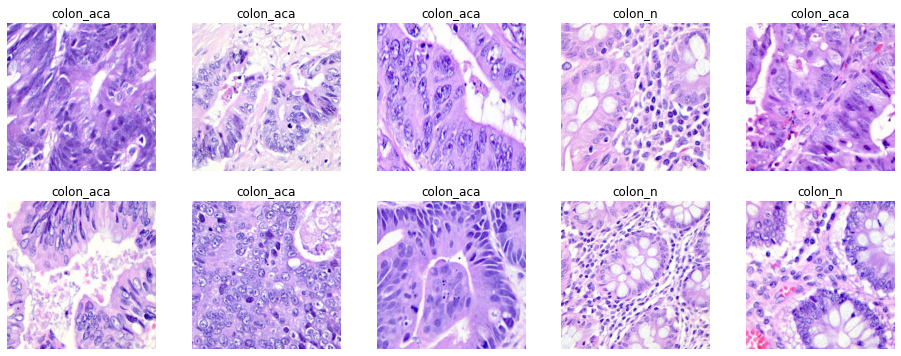

In [5]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    idx = np.random.randint(0,len(colon_datasets['train'].dataset.samples))
    image = mpimg.imread(colon_datasets['train'].dataset.samples[idx][0])
    plt.imshow(image)
    plt.title(colon_datasets['train'].dataset.classes[colon_datasets['train'].dataset.samples[idx][1]])
    plt.axis('off');

Now, let's see some of the lung images

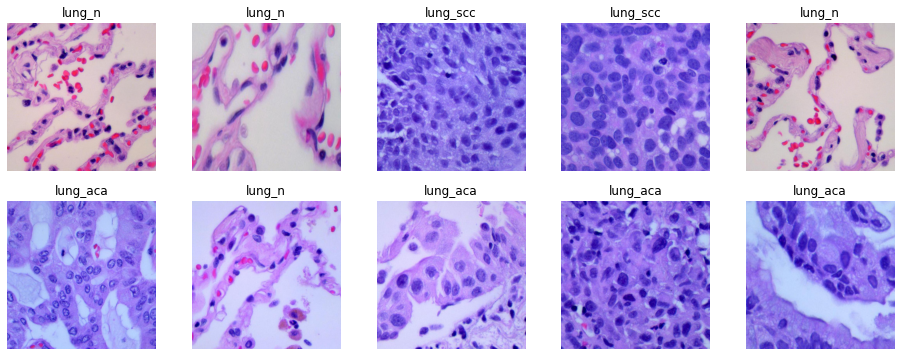

In [6]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    idx = np.random.randint(0,len(lung_datasets['train'].dataset.samples))
    image = mpimg.imread(lung_datasets['train'].dataset.samples[idx][0])
    plt.imshow(image)
    plt.title(lung_datasets['train'].dataset.classes[lung_datasets['train'].dataset.samples[idx][1]])
    plt.axis('off');

Now let's plot everything together:

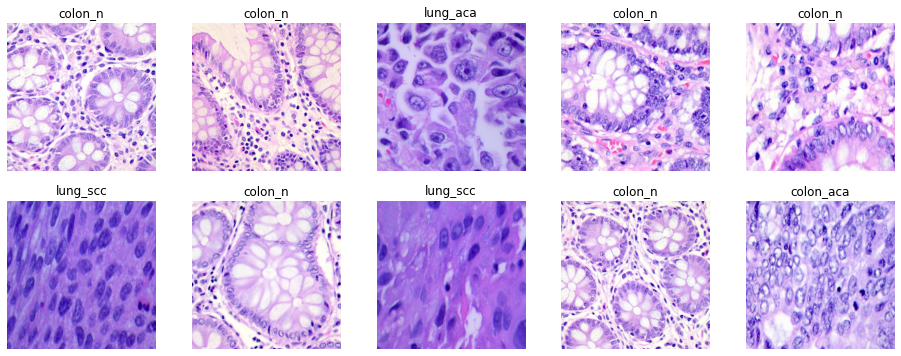

In [7]:
plt.figure(figsize=(16, 6))
for i in range(10):
    selection = random.randint(0,1)
    plt.subplot(2, 5, i + 1)
    idx = np.random.randint(0,len(total_datasets['train'].dataset.samples))
    image = mpimg.imread(total_datasets['train'].dataset.samples[idx][0])
    plt.imshow(image)
    plt.title(total_datasets['train'].dataset.classes[total_datasets['train'].dataset.samples[idx][1]])
    plt.axis('off');

In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    acc_history = {"train": [], "val": []}
    losses = {"train": [], "val": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode. Posar el model en mode train o test. Això està relacionat amb el torch no grad. Ens estalviem memoria si estem en test, ja que no emmagatzema totes les dades del gradient aleshores li diem que no la necessitarem.
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad() #si no fem això per defecte l'autograd acumula
                #els gradients de tots els forward pas. És obligatori tenint en compte la manera
                #de la que utilitzam el autograd.

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    losses[phase].append(loss.cpu().detach().numpy())

                    _, preds = torch.max(outputs, 1) #maximum, position = max(tensor, dimension)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc: #ens guardem els pesos amb els que hem obtingut un millor resultat de l'accuracy. Podem reutilitzar aquesta part per tal de fer un stopping criterion i dir que si l'accuracy no ha millorat en les últimes 5 iteracions que acabi
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            acc_history[phase].append(epoch_acc.cpu().detach().numpy()) #I changed this

        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, losses

In [9]:
@torch.no_grad()
def evaluate_model(model, loader):
    model.eval()
    total_predictions = []
    total_real_values = []
    for data, target in loader:
        data = data.to(device)
        
        output = model(data)
        
        pred = output.data.max(1, keepdim=True)[1]
        
        total_predictions.append(pred.cpu().detach().numpy())
        total_real_values.append(target.cpu().detach().numpy())
    
    total_predictions = np.array(total_predictions).reshape(1, len(total_predictions)*8)[0]
    
    total_real_values = np.array(total_real_values).reshape(1, len(total_real_values)*8)[0]
    
    n_classes = len(np.unique(total_real_values))
    
    if n_classes == 2:
        task = 'binary'
    else:
        task = 'multiclass'
    
    confmat = ConfusionMatrix(task=task, num_classes=n_classes)
        
    preds = torch.from_numpy(total_predictions)
    target = torch.from_numpy(total_real_values)
    
    return confmat(preds, target)

In [10]:
class CNN(nn.Module):
    def __init__(self, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.output_size = output_size
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size = 5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature * 4 * 4, 50)
        self.fc2 = nn.Linear(50, output_size)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, self.n_feature * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

After trying different optimizers, I've found out that the one that provides the best results is the SGD with some weight decay

In [16]:
output_size = 5

model = CNN(6, output_size)

In [17]:
model = model.to(device)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 300

learning_rate = 0.001

momentum = 0.5

lambda_l2 = 1e-5

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=lambda_l2)

# Train and evaluate
model_SGD, hist_SGD, losses_SGD = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/299
----------
train Loss: 1.6066 Acc: 0.2006
val Loss: 1.5872 Acc: 0.1976
Epoch 1/299
----------
train Loss: 1.1418 Acc: 0.4748
val Loss: 0.8748 Acc: 0.5350
Epoch 2/299
----------
train Loss: 0.7845 Acc: 0.6529
val Loss: 0.7320 Acc: 0.6490
Epoch 3/299
----------
train Loss: 0.6981 Acc: 0.6832
val Loss: 0.6391 Acc: 0.7096
Epoch 4/299
----------
train Loss: 0.6607 Acc: 0.6972
val Loss: 0.6240 Acc: 0.7266
Epoch 5/299
----------
train Loss: 0.6321 Acc: 0.7177
val Loss: 0.6789 Acc: 0.6636
Epoch 6/299
----------
train Loss: 0.6160 Acc: 0.7297
val Loss: 0.6376 Acc: 0.7172
Epoch 7/299
----------
train Loss: 0.5951 Acc: 0.7397
val Loss: 0.5778 Acc: 0.7522
Epoch 8/299
----------
train Loss: 0.5816 Acc: 0.7452
val Loss: 0.5533 Acc: 0.7656
Epoch 9/299
----------
train Loss: 0.5646 Acc: 0.7560
val Loss: 0.5460 Acc: 0.7644
Epoch 10/299
----------
train Loss: 0.5494 Acc: 0.7665
val Loss: 0.5221 Acc: 0.7850
Epoch 11/299
----------
train Loss: 0.5379 Acc: 0.7720
val Loss: 0.5332 Acc: 0.7628
Ep

val Loss: 0.2034 Acc: 0.9150
Epoch 98/299
----------
train Loss: 0.1773 Acc: 0.9294
val Loss: 0.1912 Acc: 0.9254
Epoch 99/299
----------
train Loss: 0.1726 Acc: 0.9325
val Loss: 0.2015 Acc: 0.9202
Epoch 100/299
----------
train Loss: 0.1698 Acc: 0.9333
val Loss: 0.1938 Acc: 0.9202
Epoch 101/299
----------
train Loss: 0.1725 Acc: 0.9303
val Loss: 0.1937 Acc: 0.9216
Epoch 102/299
----------
train Loss: 0.1709 Acc: 0.9320
val Loss: 0.1777 Acc: 0.9310
Epoch 103/299
----------
train Loss: 0.1691 Acc: 0.9328
val Loss: 0.1920 Acc: 0.9256
Epoch 104/299
----------
train Loss: 0.1658 Acc: 0.9341
val Loss: 0.1835 Acc: 0.9286
Epoch 105/299
----------
train Loss: 0.1689 Acc: 0.9354
val Loss: 0.2348 Acc: 0.9020
Epoch 106/299
----------
train Loss: 0.1638 Acc: 0.9339
val Loss: 0.1853 Acc: 0.9280
Epoch 107/299
----------
train Loss: 0.1621 Acc: 0.9361
val Loss: 0.1839 Acc: 0.9268
Epoch 108/299
----------
train Loss: 0.1655 Acc: 0.9337
val Loss: 0.2059 Acc: 0.9138
Epoch 109/299
----------
train Loss: 0

train Loss: 0.0931 Acc: 0.9635
val Loss: 0.1699 Acc: 0.9394
Epoch 195/299
----------
train Loss: 0.0919 Acc: 0.9631
val Loss: 0.1765 Acc: 0.9384
Epoch 196/299
----------
train Loss: 0.0930 Acc: 0.9653
val Loss: 0.1689 Acc: 0.9396
Epoch 197/299
----------
train Loss: 0.0909 Acc: 0.9642
val Loss: 0.1842 Acc: 0.9348
Epoch 198/299
----------
train Loss: 0.1010 Acc: 0.9634
val Loss: 0.1683 Acc: 0.9408
Epoch 199/299
----------
train Loss: 0.0888 Acc: 0.9662
val Loss: 0.1671 Acc: 0.9412
Epoch 200/299
----------
train Loss: 0.0920 Acc: 0.9643
val Loss: 0.1697 Acc: 0.9418
Epoch 201/299
----------
train Loss: 0.0882 Acc: 0.9670
val Loss: 0.1971 Acc: 0.9306
Epoch 202/299
----------
train Loss: 0.0897 Acc: 0.9650
val Loss: 0.1943 Acc: 0.9320
Epoch 203/299
----------
train Loss: 0.0889 Acc: 0.9646
val Loss: 0.1624 Acc: 0.9422
Epoch 204/299
----------
train Loss: 0.0867 Acc: 0.9662
val Loss: 0.1706 Acc: 0.9402
Epoch 205/299
----------
train Loss: 0.0850 Acc: 0.9667
val Loss: 0.1841 Acc: 0.9314
Epoch

train Loss: 0.0585 Acc: 0.9792
val Loss: 0.2349 Acc: 0.9322
Epoch 292/299
----------
train Loss: 0.0493 Acc: 0.9816
val Loss: 0.1899 Acc: 0.9444
Epoch 293/299
----------
train Loss: 0.0533 Acc: 0.9811
val Loss: 0.2106 Acc: 0.9410
Epoch 294/299
----------
train Loss: 0.0534 Acc: 0.9801
val Loss: 0.2029 Acc: 0.9420
Epoch 295/299
----------
train Loss: 0.0498 Acc: 0.9822
val Loss: 0.2478 Acc: 0.9258
Epoch 296/299
----------
train Loss: 0.0519 Acc: 0.9806
val Loss: 0.1993 Acc: 0.9426
Epoch 297/299
----------
train Loss: 0.0551 Acc: 0.9794
val Loss: 0.2398 Acc: 0.9306
Epoch 298/299
----------
train Loss: 0.0503 Acc: 0.9817
val Loss: 0.1955 Acc: 0.9480
Epoch 299/299
----------
train Loss: 0.0453 Acc: 0.9832
val Loss: 0.1858 Acc: 0.9518
Training complete in 232m 25s
Best val Acc: 0.951800


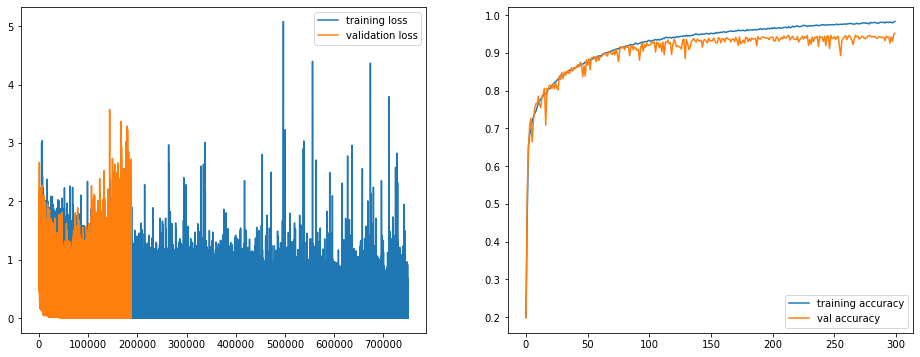

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


ax1.plot(losses_SGD["train"], label="training loss")
ax1.plot(losses_SGD["val"], label="validation loss")
ax1.legend()

ax2.plot(hist_SGD["train"],label="training accuracy")
ax2.plot(hist_SGD["val"],label="val accuracy")
ax2.legend()

plt.show()  

In [19]:
confmat = evaluate_model(model_SGD, dataloaders_dict['val']).numpy()
disp = ConfusionMatrixDisplay(confmat, display_labels=dataloaders_dict['val'].dataset.dataset.classes)

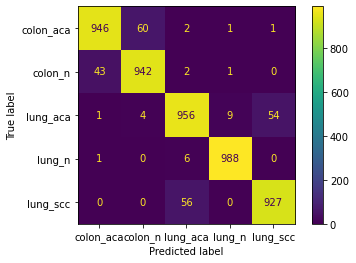

In [20]:
disp.plot()

We've obtained an overall accuracy of 95,18%. If we have a look at the confusion matrix, we can see that the majority of the errors are among the 'colon_aca' and 'colon_n' classes and among the 'lung_aca', 'lung_n' and 'lung_scc' classes. That means that our model indirectly is able to distinguish between a colon image and a lung image. Now let's try to split our model into two different classifiers, the first one for lung classification, and the second one for colon classification. Let's try to find out if the accuracy is improved:

Now let's try to do only lung classification:

In [26]:
output_size = 3

model = CNN(6, output_size)

In [27]:
model = model.to(device)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 300

learning_rate = 0.001

momentum = 0.5

lambda_l2 = 1e-5

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=lambda_l2)

# Train and evaluate
model_lung_SGD, hist_lung_SGD, losses_lung_SGD = train_model(model, lung_dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/299
----------
train Loss: 1.1001 Acc: 0.3318
val Loss: 1.0955 Acc: 0.3393
Epoch 1/299
----------
train Loss: 1.0695 Acc: 0.4518
val Loss: 0.9653 Acc: 0.5113
Epoch 2/299
----------
train Loss: 0.7324 Acc: 0.6461
val Loss: 0.6353 Acc: 0.6680
Epoch 3/299
----------
train Loss: 0.6011 Acc: 0.6897
val Loss: 0.5841 Acc: 0.6917
Epoch 4/299
----------
train Loss: 0.5652 Acc: 0.7054
val Loss: 0.5585 Acc: 0.6953
Epoch 5/299
----------
train Loss: 0.5433 Acc: 0.7177
val Loss: 0.5477 Acc: 0.7243
Epoch 6/299
----------
train Loss: 0.5283 Acc: 0.7260
val Loss: 0.5361 Acc: 0.7053
Epoch 7/299
----------
train Loss: 0.5150 Acc: 0.7372
val Loss: 0.5266 Acc: 0.7430
Epoch 8/299
----------
train Loss: 0.5044 Acc: 0.7454
val Loss: 0.5267 Acc: 0.7147
Epoch 9/299
----------
train Loss: 0.4926 Acc: 0.7530
val Loss: 0.5031 Acc: 0.7307
Epoch 10/299
----------
train Loss: 0.4783 Acc: 0.7699
val Loss: 0.4912 Acc: 0.7640
Epoch 11/299
----------
train Loss: 0.4573 Acc: 0.7895
val Loss: 0.4479 Acc: 0.8093
Ep

val Loss: 0.1569 Acc: 0.9410
Epoch 98/299
----------
train Loss: 0.1511 Acc: 0.9407
val Loss: 0.1823 Acc: 0.9237
Epoch 99/299
----------
train Loss: 0.1502 Acc: 0.9417
val Loss: 0.1511 Acc: 0.9427
Epoch 100/299
----------
train Loss: 0.1483 Acc: 0.9436
val Loss: 0.1515 Acc: 0.9420
Epoch 101/299
----------
train Loss: 0.1491 Acc: 0.9421
val Loss: 0.1565 Acc: 0.9367
Epoch 102/299
----------
train Loss: 0.1472 Acc: 0.9410
val Loss: 0.1551 Acc: 0.9393
Epoch 103/299
----------
train Loss: 0.1465 Acc: 0.9425
val Loss: 0.1525 Acc: 0.9393
Epoch 104/299
----------
train Loss: 0.1457 Acc: 0.9441
val Loss: 0.1474 Acc: 0.9417
Epoch 105/299
----------
train Loss: 0.1441 Acc: 0.9438
val Loss: 0.1459 Acc: 0.9433
Epoch 106/299
----------
train Loss: 0.1429 Acc: 0.9450
val Loss: 0.1425 Acc: 0.9450
Epoch 107/299
----------
train Loss: 0.1407 Acc: 0.9447
val Loss: 0.1557 Acc: 0.9343
Epoch 108/299
----------
train Loss: 0.1414 Acc: 0.9446
val Loss: 0.1479 Acc: 0.9443
Epoch 109/299
----------
train Loss: 0

train Loss: 0.0737 Acc: 0.9719
val Loss: 0.1095 Acc: 0.9573
Epoch 195/299
----------
train Loss: 0.0740 Acc: 0.9718
val Loss: 0.1106 Acc: 0.9567
Epoch 196/299
----------
train Loss: 0.0737 Acc: 0.9717
val Loss: 0.1152 Acc: 0.9597
Epoch 197/299
----------
train Loss: 0.0732 Acc: 0.9722
val Loss: 0.1176 Acc: 0.9530
Epoch 198/299
----------
train Loss: 0.0726 Acc: 0.9732
val Loss: 0.1224 Acc: 0.9527
Epoch 199/299
----------
train Loss: 0.0717 Acc: 0.9725
val Loss: 0.1220 Acc: 0.9540
Epoch 200/299
----------
train Loss: 0.0699 Acc: 0.9742
val Loss: 0.1135 Acc: 0.9567
Epoch 201/299
----------
train Loss: 0.0702 Acc: 0.9744
val Loss: 0.1142 Acc: 0.9567
Epoch 202/299
----------
train Loss: 0.0700 Acc: 0.9748
val Loss: 0.1338 Acc: 0.9510
Epoch 203/299
----------
train Loss: 0.0691 Acc: 0.9752
val Loss: 0.1147 Acc: 0.9583
Epoch 204/299
----------
train Loss: 0.0668 Acc: 0.9765
val Loss: 0.1181 Acc: 0.9567
Epoch 205/299
----------
train Loss: 0.0663 Acc: 0.9769
val Loss: 0.1147 Acc: 0.9560
Epoch

train Loss: 0.0372 Acc: 0.9878
val Loss: 0.1159 Acc: 0.9647
Epoch 292/299
----------
train Loss: 0.0357 Acc: 0.9881
val Loss: 0.1111 Acc: 0.9640
Epoch 293/299
----------
train Loss: 0.0365 Acc: 0.9876
val Loss: 0.1438 Acc: 0.9543
Epoch 294/299
----------
train Loss: 0.0363 Acc: 0.9875
val Loss: 0.1305 Acc: 0.9610
Epoch 295/299
----------
train Loss: 0.0337 Acc: 0.9889
val Loss: 0.1219 Acc: 0.9607
Epoch 296/299
----------
train Loss: 0.0354 Acc: 0.9882
val Loss: 0.1256 Acc: 0.9610
Epoch 297/299
----------
train Loss: 0.0355 Acc: 0.9892
val Loss: 0.1139 Acc: 0.9627
Epoch 298/299
----------
train Loss: 0.0330 Acc: 0.9901
val Loss: 0.1186 Acc: 0.9630
Epoch 299/299
----------
train Loss: 0.0355 Acc: 0.9882
val Loss: 0.1182 Acc: 0.9643
Training complete in 133m 27s
Best val Acc: 0.966333


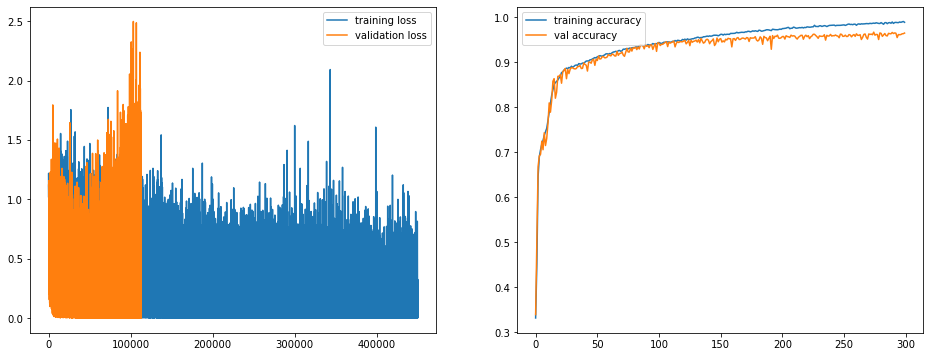

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


ax1.plot(losses_lung_SGD["train"], label="training loss")
ax1.plot(losses_lung_SGD["val"], label="validation loss")
ax1.legend()

ax2.plot(hist_lung_SGD["train"],label="training accuracy")
ax2.plot(hist_lung_SGD["val"],label="val accuracy")
ax2.legend()

plt.show()  

In [35]:
confmat = evaluate_model(model_lung_SGD, lung_dataloaders_dict['val']).numpy()
disp = ConfusionMatrixDisplay(confmat, display_labels=lung_dataloaders_dict['val'].dataset.dataset.classes)

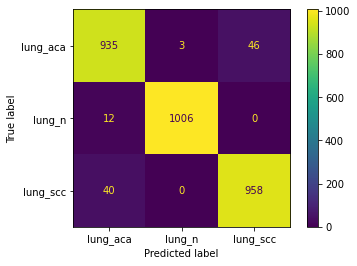

In [36]:
disp.plot()

Now let's try some colon classification

In [30]:
output_size = 2

model = CNN(6, output_size)

In [31]:
model = model.to(device)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 300

learning_rate = 0.001

momentum = 0.5

lambda_l2 = 1e-5

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=lambda_l2)

# Train and evaluate
model_colon_SGD, hist_colon_SGD, losses_colon_SGD = train_model(model, colon_dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/299
----------
train Loss: 0.6932 Acc: 0.4960
val Loss: 0.6929 Acc: 0.5035
Epoch 1/299
----------
train Loss: 0.6931 Acc: 0.5038
val Loss: 0.6929 Acc: 0.5790
Epoch 2/299
----------
train Loss: 0.6929 Acc: 0.5222
val Loss: 0.6927 Acc: 0.5040
Epoch 3/299
----------
train Loss: 0.6928 Acc: 0.5116
val Loss: 0.6925 Acc: 0.5080
Epoch 4/299
----------
train Loss: 0.6926 Acc: 0.5194
val Loss: 0.6925 Acc: 0.6730
Epoch 5/299
----------
train Loss: 0.6925 Acc: 0.5242
val Loss: 0.6923 Acc: 0.7100
Epoch 6/299
----------
train Loss: 0.6923 Acc: 0.5176
val Loss: 0.6919 Acc: 0.5090
Epoch 7/299
----------
train Loss: 0.6921 Acc: 0.5356
val Loss: 0.6915 Acc: 0.5040
Epoch 8/299
----------
train Loss: 0.6917 Acc: 0.5369
val Loss: 0.6914 Acc: 0.6635
Epoch 9/299
----------
train Loss: 0.6914 Acc: 0.5329
val Loss: 0.6914 Acc: 0.4960
Epoch 10/299
----------
train Loss: 0.6908 Acc: 0.5381
val Loss: 0.6904 Acc: 0.5070
Epoch 11/299
----------
train Loss: 0.6900 Acc: 0.5580
val Loss: 0.6891 Acc: 0.5040
Ep

val Loss: 0.2460 Acc: 0.8975
Epoch 98/299
----------
train Loss: 0.2209 Acc: 0.9104
val Loss: 0.2821 Acc: 0.8745
Epoch 99/299
----------
train Loss: 0.2202 Acc: 0.9121
val Loss: 0.2292 Acc: 0.9130
Epoch 100/299
----------
train Loss: 0.2186 Acc: 0.9124
val Loss: 0.2354 Acc: 0.9030
Epoch 101/299
----------
train Loss: 0.2103 Acc: 0.9163
val Loss: 0.2276 Acc: 0.9065
Epoch 102/299
----------
train Loss: 0.2100 Acc: 0.9158
val Loss: 0.2240 Acc: 0.9095
Epoch 103/299
----------
train Loss: 0.2069 Acc: 0.9169
val Loss: 0.2152 Acc: 0.9125
Epoch 104/299
----------
train Loss: 0.2053 Acc: 0.9185
val Loss: 0.2583 Acc: 0.8920
Epoch 105/299
----------
train Loss: 0.2033 Acc: 0.9198
val Loss: 0.2287 Acc: 0.9020
Epoch 106/299
----------
train Loss: 0.2026 Acc: 0.9191
val Loss: 0.2078 Acc: 0.9185
Epoch 107/299
----------
train Loss: 0.2003 Acc: 0.9204
val Loss: 0.2347 Acc: 0.9045
Epoch 108/299
----------
train Loss: 0.2001 Acc: 0.9164
val Loss: 0.2064 Acc: 0.9140
Epoch 109/299
----------
train Loss: 0

train Loss: 0.0871 Acc: 0.9671
val Loss: 0.1925 Acc: 0.9340
Epoch 195/299
----------
train Loss: 0.0867 Acc: 0.9665
val Loss: 0.1679 Acc: 0.9430
Epoch 196/299
----------
train Loss: 0.0830 Acc: 0.9683
val Loss: 0.2342 Acc: 0.9195
Epoch 197/299
----------
train Loss: 0.0865 Acc: 0.9660
val Loss: 0.1624 Acc: 0.9430
Epoch 198/299
----------
train Loss: 0.0826 Acc: 0.9683
val Loss: 0.1708 Acc: 0.9405
Epoch 199/299
----------
train Loss: 0.0867 Acc: 0.9673
val Loss: 0.1759 Acc: 0.9325
Epoch 200/299
----------
train Loss: 0.0875 Acc: 0.9671
val Loss: 0.1706 Acc: 0.9430
Epoch 201/299
----------
train Loss: 0.0811 Acc: 0.9685
val Loss: 0.1717 Acc: 0.9375
Epoch 202/299
----------
train Loss: 0.0788 Acc: 0.9696
val Loss: 0.1804 Acc: 0.9400
Epoch 203/299
----------
train Loss: 0.0793 Acc: 0.9701
val Loss: 0.1732 Acc: 0.9445
Epoch 204/299
----------
train Loss: 0.0809 Acc: 0.9680
val Loss: 0.1726 Acc: 0.9420
Epoch 205/299
----------
train Loss: 0.0785 Acc: 0.9685
val Loss: 0.1723 Acc: 0.9420
Epoch

train Loss: 0.0340 Acc: 0.9908
val Loss: 0.2068 Acc: 0.9360
Epoch 292/299
----------
train Loss: 0.0293 Acc: 0.9914
val Loss: 0.1866 Acc: 0.9515
Epoch 293/299
----------
train Loss: 0.0338 Acc: 0.9891
val Loss: 0.2298 Acc: 0.9400
Epoch 294/299
----------
train Loss: 0.0288 Acc: 0.9915
val Loss: 0.1741 Acc: 0.9505
Epoch 295/299
----------
train Loss: 0.0327 Acc: 0.9903
val Loss: 0.1849 Acc: 0.9505
Epoch 296/299
----------
train Loss: 0.0342 Acc: 0.9886
val Loss: 0.1920 Acc: 0.9485
Epoch 297/299
----------
train Loss: 0.0301 Acc: 0.9914
val Loss: 0.2069 Acc: 0.9445
Epoch 298/299
----------
train Loss: 0.0284 Acc: 0.9919
val Loss: 0.1882 Acc: 0.9460
Epoch 299/299
----------
train Loss: 0.0293 Acc: 0.9916
val Loss: 0.1833 Acc: 0.9495
Training complete in 95m 33s
Best val Acc: 0.951500


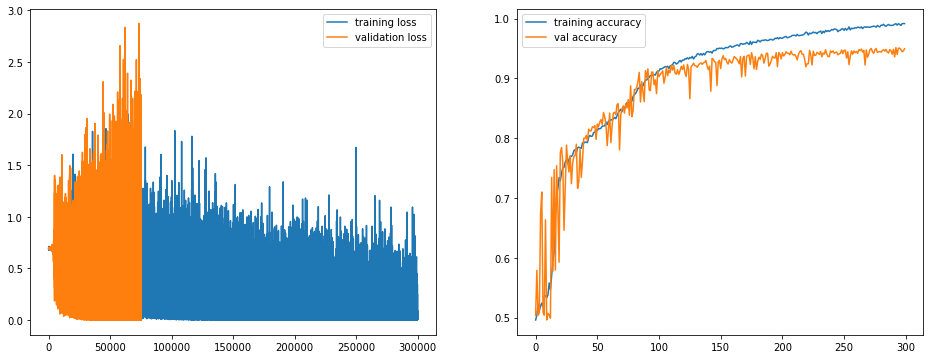

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


ax1.plot(losses_colon_SGD["train"], label="training loss")
ax1.plot(losses_colon_SGD["val"], label="validation loss")
ax1.legend()

ax2.plot(hist_colon_SGD["train"],label="training accuracy")
ax2.plot(hist_colon_SGD["val"],label="val accuracy")
ax2.legend()

plt.show()  

In [33]:
confmat = evaluate_model(model_colon_SGD, colon_dataloaders_dict['val']).numpy()
disp = ConfusionMatrixDisplay(confmat, display_labels=colon_dataloaders_dict['val'].dataset.dataset.classes)

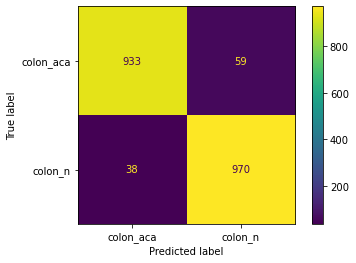

In [34]:
disp.plot()